https://www.tensorflow.org/tutorials/load_data/images
    
    https://www.tensorflow.org/datasets/splits

In [1]:
import numpy as np
import pandas as pd
# ADD project path instead of module path
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))
from ets2drive.helpers import read_yaml, read_json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# allow gpu to run
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
config_path = "../config/config.yml"
config = read_yaml(os.path.abspath(config_path))

In [4]:
os.listdir(config['csv_folder'])

['2021-01-01_02_01_30.csv']

In [5]:
run_name= '2021-01-01_02_01_30'

In [6]:
data = pd.read_csv(config['csv_folder'] + '/2021-01-01_02_01_30.csv')

In [7]:
data.head(95)

,img,speed,cruiseControlSpeed,cruiseControlOn,userSteer,userThrottle,userBrake,wipersOn,blinkerLeftActive,blinkerRightActive,...,trailerRoll,speedLimit,remainingTime,estimatedTime,estimatedDistance,lightsBeamLowOn,lightsBeamHighOn,gemeSteer,gameThrottle,gameBrake
0,0201_32.3.jpg,0.025220,0.0,False,0.0,0.000000,0.0,False,False,False,...,0.000038,50,0001-01-01T08:09:00Z,0001-01-01T04:09:31Z,315169,False,False,-0.028519,0.000000e+00,1.0
1,0201_32.4.jpg,0.025217,0.0,False,0.0,0.000000,0.0,False,False,False,...,0.000038,50,0001-01-01T08:09:00Z,0001-01-01T04:09:31Z,315169,False,False,-0.028514,0.000000e+00,1.0
2,0201_32.6.jpg,0.025228,0.0,False,0.0,0.159493,0.0,False,False,False,...,0.000038,50,0001-01-01T08:09:00Z,0001-01-01T04:09:31Z,315169,False,False,-0.028509,0.000000e+00,0.0
3,0201_32.8.jpg,0.024547,0.0,False,0.0,0.652445,0.0,False,False,False,...,0.000038,50,0001-01-01T08:09:00Z,0001-01-01T04:09:31Z,315169,False,False,-0.028505,3.202228e-01,0.0
4,0201_33.0.jpg,0.042653,0.0,False,0.0,1.000000,0.0,False,False,False,...,0.000038,50,0001-01-01T08:09:00Z,0001-01-01T04:09:31Z,315169,False,False,-0.028499,9.746654e-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0201_50.9.jpg,28.587934,0.0,False,0.0,0.000000,0.0,False,True,False,...,0.000135,50,0001-01-01T08:08:00Z,0001-01-01T04:08:48Z,314855,False,False,0.012618,1.401298e-45,0.0
91,0201_51.1.jpg,27.920840,0.0,False,0.0,0.000000,0.0,False,True,False,...,0.000053,50,0001-01-01T08:08:00Z,0001-01-01T04:08:48Z,314850,False,False,0.010858,1.401298e-45,0.0
92,0201_51.3.jpg,27.366650,0.0,False,1.0,0.000000,0.0,False,True,False,...,0.000011,50,0001-01-01T08:08:00Z,0001-01-01T04:08:47Z,314845,False,False,0.041630,1.401298e-45,0.0
93,0201_51.5.jpg,26.857437,0.0,False,1.0,0.000000,0.0,False,True,False,...,-0.000077,50,0001-01-01T08:08:00Z,0001-01-01T04:08:47Z,314841,False,False,0.102846,1.401298e-45,0.0


### generate labels
left steer: userSteer = 1
right turn: userSteer = -1

In [8]:
def generateTriggerFeature(data, reference, triggerFeature):
    data[triggerFeature] = [0] * len(data)
    for i in range(1, len(data)):
        if data[reference][i-1] != data[reference][i]:
            data[triggerFeature][i] = 1

In [9]:
data['userBrake'] = (data['userBrake'] > 0) * 1
data['userThrottle'] = (data['userThrottle'] > 0) * 1
data['userLeftTurn'] = (data['userSteer'] > 0) * 1
data['userRightTurn'] = (data['userSteer'] < 0) * 1
# generate cruise control trigger
generateTriggerFeature(data, 'cruiseControlOn', 'userCruiseControlTrigger')
# generate left indicator trigger
generateTriggerFeature(data, 'blinkerLeftActive', 'userLeftTurnTrigger')
# generate right indicator trigger
generateTriggerFeature(data, 'blinkerRightActive', 'userRightTurnTrigger')

<ipython-input-8-7418ce3c5d71>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[triggerFeature][i] = 1


(array([3179.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1325.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

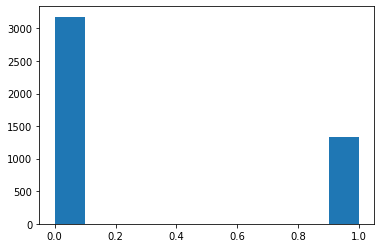

In [10]:
plt.hist(data['userThrottle'])

(array([4470.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          34.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

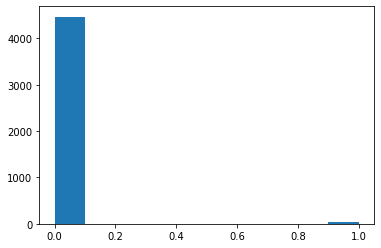

In [11]:
plt.hist(data['userCruiseControlTrigger'])

(array([2214.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2290.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

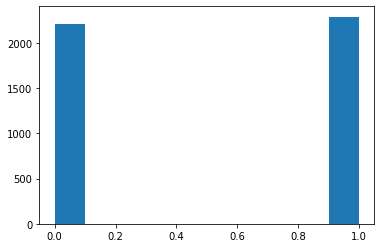

In [12]:
plt.hist(data['cruiseControlOn']*1)

(array([3179.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1325.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

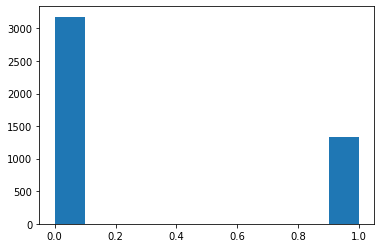

In [13]:
plt.hist(data['userThrottle'])

(array([4327.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         177.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

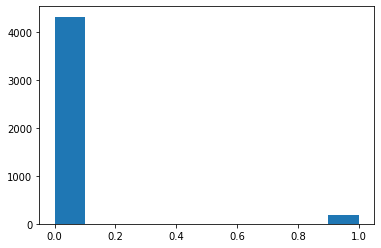

In [14]:
plt.hist(data['userBrake'])

(array([ 329.,    0.,    0.,    0.,    0., 3852.,    0.,    0.,    0.,
         323.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

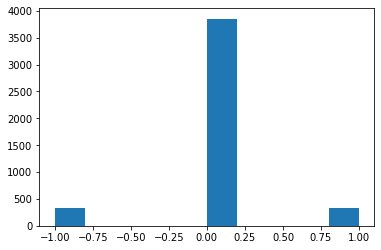

In [15]:
plt.hist(data['userSteer'])

(array([4470.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          34.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

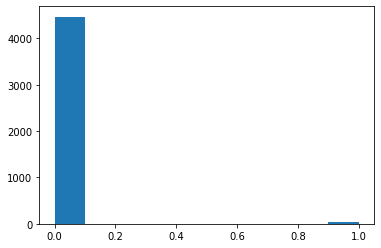

In [16]:
plt.hist(data['userCruiseControlTrigger'])

#### Get all image paths and all labels
Predicting:
- userThrottle
- userBrake
- userLeftTurn
- userRightTurn
- userCruiseControlTrigger
- userLeftTurnTrigger
- userRightTurnTrigger

In [17]:
img_dir = os.path.join(config['img_folder'], os.listdir(config['img_folder'])[0])

all_image_paths = np.array(data['img'])
for i in range(len(all_image_paths)):
    all_image_paths[i] = os.path.join(img_dir, all_image_paths[i])

all_image_labels = np.array(data[config['label_columns']])

In [18]:
BATCH_SIZE = config['BATCH_SIZE']
NO_OUTPUTS = len(config['label_columns'])

# dataset
create custom dataset using `Dataset.map`  
https://www.tensorflow.org/tutorials/load_data/images

#### Create dataset of image paths and labels

In [19]:
all_image_labels[100:110]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]], dtype=int64)

In [20]:
all_image_labels[100:110]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]], dtype=int64)

In [21]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

img_count = len(all_image_paths)
print(img_count)

img_count = len(all_image_paths)
ds = ds.shuffle(img_count)
val_size = int(img_count * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

4504
3604
900


#### use map to load images and create actual dataset(from previous dataset) suitable for training

In [22]:
resized_H = config['resize_H']
resized_W = config['resize_W']
def load_and_preprocess_image(path):
    raw_img = tf.io.read_file(path)
    return preprocess_image(raw_img, resized_H, resized_W)

def preprocess_image(raw_img, h, w):
    img = tf.image.decode_jpeg(raw_img, channels=3)
    # img = tf.image.resize(img, )
    return tf.image.resize(img, [h, w])


# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

train_ds = train_ds.map(load_and_preprocess_from_path_label)
val_ds = val_ds.map(load_and_preprocess_from_path_label)

mapped dataset to batched dataset

In [23]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


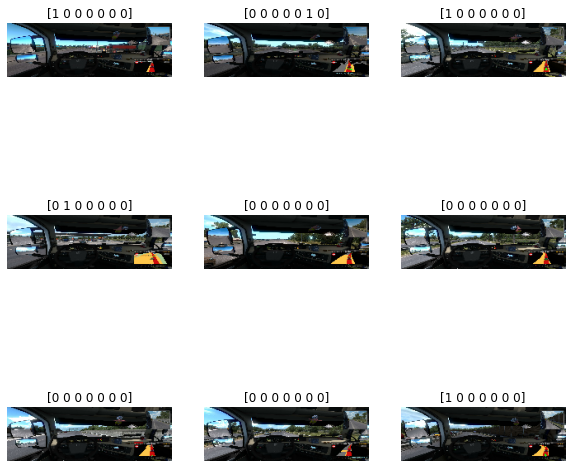

In [24]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")


# increase performance by prefetching and caching

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(24, 5, 2, activation='relu'),
    layers.Conv2D(36, 5, 2, activation='relu'),
    layers.Conv2D(48, 5, 2, activation='relu'),

    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),

    # layers.Conv2D(32, 3, activation='relu'),
    # layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1164, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(NO_OUTPUTS, activation='sigmoid')
])

model.compile(optimizer='RMSprop', loss='mse')
# model.build()
# model.summary()

In [33]:
model.fit(train_ds, validation_data=val_ds, epochs=25, verbose=1)

Epoch 1/25
113/113 [==============================] - 3s 17ms/step - loss: 0.1609 - val_loss: 0.0647
Epoch 2/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0630 - val_loss: 0.0582
Epoch 3/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0559 - val_loss: 0.0484
Epoch 4/25
113/113 [==============================] - 2s 15ms/step - loss: 0.0420 - val_loss: 0.0348
Epoch 5/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0387 - val_loss: 0.0331
Epoch 6/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0363 - val_loss: 0.0315
Epoch 7/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0344 - val_loss: 0.0306
Epoch 8/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0335 - val_loss: 0.0280
Epoch 9/25
113/113 [==============================] - 2s 16ms/step - loss: 0.0317 - val_loss: 0.0335
Epoch 10/25
113/113 [==============================] - 2s 15ms/step - loss: 0.0301 - val_lo

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

##### Save entire model temporarily

In [34]:
model_name = '5fps'
model_path = os.path.join(config['model_folder'], model_name)
os.makedirs(model_path, exist_ok=True)
model.save(model_path)

INFO:tensorflow:Assets written to: D:/data/autonomous_ets2_data/model\5fps\assets


In [27]:
new_model = tf.keras.models.load_model(model_path)

In [32]:
image_batch, label_batch = next(iter(val_ds))
test = tf.expand_dims(image_batch[0], 0)
model.predict(test)

array([[3.25584680e-01, 1.27511972e-03, 3.33023863e-03, 5.35085378e-03,
        2.49482326e-07, 2.61396690e-06, 1.36673625e-05]], dtype=float32)

In [40]:
from PIL import ImageGrab

In [122]:
im = ImageGrab.grab()
im = tf.keras.preprocessing.image.img_to_array(im, dtype=np.float64)
im = tf.convert_to_tensor(im)
im = tf.image.resize(im, [resized_H, resized_W])
# im =

In [ ]:
test = tf.expand_dims(image_batch[0], 0)


In [126]:
model.predict( tf.expand_dims(im, 0))

array([[0.39343703, 0.06734387, 0.12337501, 0.12282495, 0.0028356 ,
        0.00725658, 0.01360804]], dtype=float32)

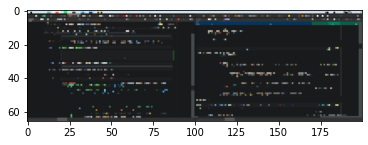

In [123]:
plt.imshow(im.numpy().astype("uint8"))

In [88]:
test

<tf.Tensor: shape=(1, 66, 200, 3), dtype=float32, numpy=
array([[[[ 73.318184, 150.31818 , 196.31818 ],
         [ 71.681816, 148.68182 , 194.68182 ],
         [ 63.522728, 149.25    , 192.29546 ],
         ...,
         [ 38.045044,  39.72686 ,  34.40868 ],
         [ 36.145332,  38.50897 ,  31.190784],
         [ 39.159042,  41.52268 ,  34.204494]],

        [[ 79.      , 157.      , 205.      ],
         [ 77.      , 155.      , 203.      ],
         [ 77.02273 , 153.02272 , 202.02272 ],
         ...,
         [ 14.500577,  21.95499 ,  26.364437],
         [ 14.00464 ,  22.00464 ,  24.963736],
         [ 19.440983,  27.440983,  30.40916 ]],

        [[ 83.      , 163.      , 212.      ],
         [ 82.      , 162.      , 211.      ],
         [ 80.704544, 160.70454 , 209.70454 ],
         ...,
         [ 34.977283,  33.977283,  28.977285],
         [ 32.550133,  31.550135,  26.550135],
         [ 37.10916 ,  36.10916 ,  31.109161]],

        ...,

        [[ 94.60891 ,  89.60891 ,  

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>

In [39]:
model

In [38]:
THRESHOLD = 0.5
image_batch, label_batch = next(iter(val_ds))
pred = model.predict(image_batch)
pred = (pred > THRESHOLD) * 1

In [41]:
model.predict(image_batch[0])

ValueError: in user code:

    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\shiji\miniconda3\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 200, 3)


In [49]:
test = tf.expand_dims(image_batch[0], 0)
model.predict(test)

array([[1.0000000e+00, 3.4870202e-35, 0.0000000e+00, 1.7909765e-09,
        5.9353712e-30, 2.0402954e-19, 1.3591602e-20]], dtype=float32)

In [40]:
label_batch

<tf.Tensor: shape=(32, 7), dtype=int64, numpy=
array([[0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 

In [39]:
pred

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]])

In [26]:
image_batch/255

NameError: name 'image_batch' is not defined